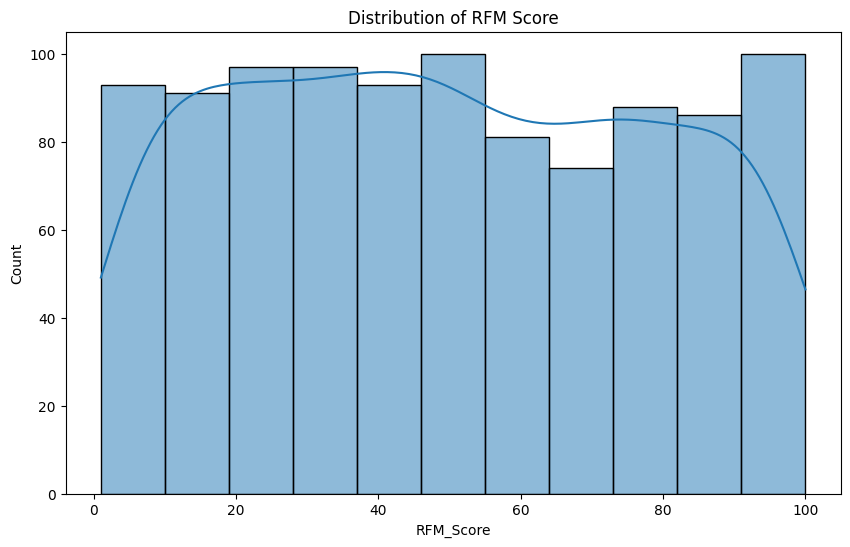

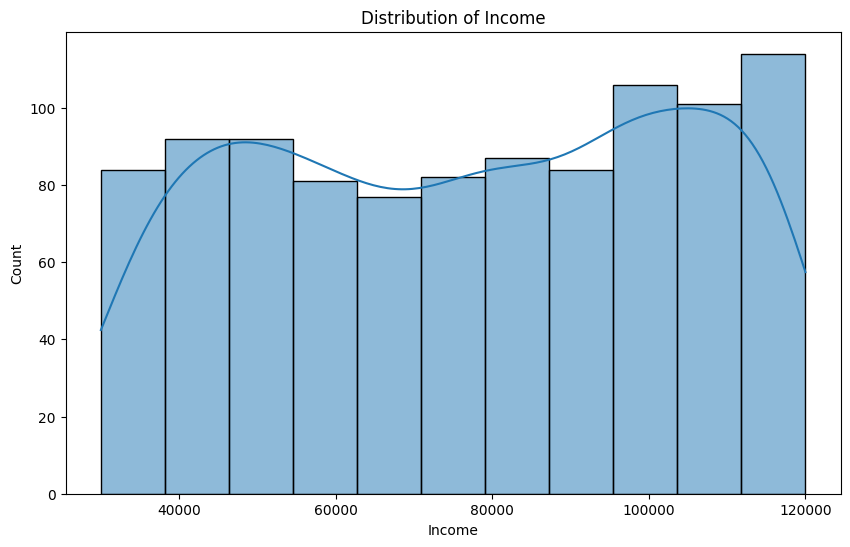

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Step 1: Load the CSV data
data = pd.read_csv('D:/Jupyter_projects/RFM_loan/simulated_lendingclub_dataset_enhanced.csv')

# Step 2: EDA and Visualization
# Plot distribution of RFM Score
plt.figure(figsize=(10, 6))
sns.histplot(data['RFM_Score'], kde=True)
plt.title('Distribution of RFM Score')
plt.show()

# Plot Income distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Income'], kde=True)
plt.title('Distribution of Income')
plt.show()


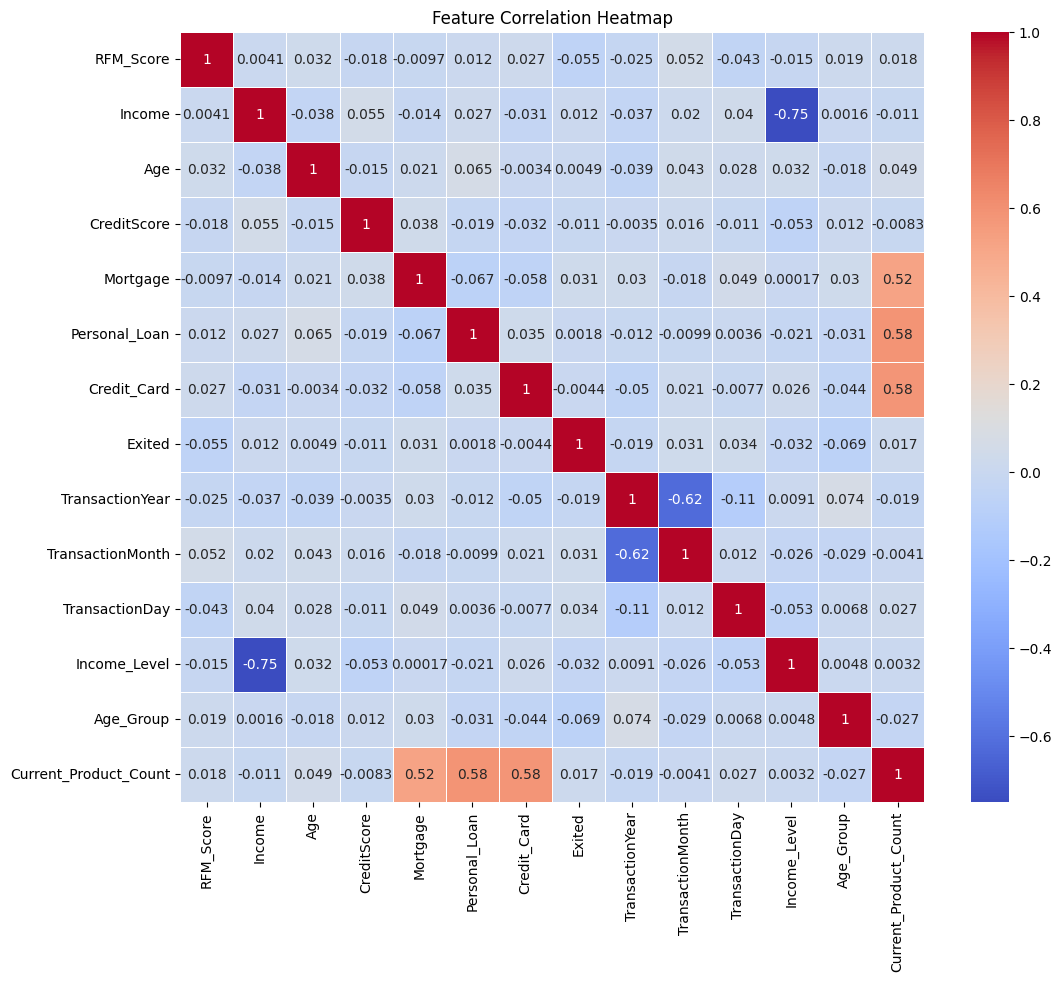

In [10]:
# Feature Correlation Heatmap with numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('CustomerID') if 'CustomerID' in numerical_cols else None
plt.figure(figsize=(12, 10))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [8]:


# Step 3: Modify dataset to create features for cross-sell and upsell
data['Income_Bin'] = pd.cut(data['Income'], bins=[0, 40000, 80000, 120000, np.inf], labels=[0, 1, 2, 3])
data['Age_Bin'] = pd.cut(data['Age'], bins=[0, 25, 35, 50, np.inf], labels=[0, 1, 2, 3])
data['CreditScore_Bin'] = pd.cut(data['CreditScore'], bins=[0, 300, 600, 750, np.inf], labels=[0, 1, 2, 3])

# Map EngagementLevel to binary values
data['EngagementLevel'] = data['EngagementLevel'].map({'Low': 0, 'High': 1})

# Step 4: Prepare target variables for multi-label classification
# Identify products the customer does not have
data['Recommend_Mortgage'] = data['Mortgage'].apply(lambda x: 1 if x == 0 else 0)
data['Recommend_Personal_Loan'] = data['Personal_Loan'].apply(lambda x: 1 if x == 0 else 0)
data['Recommend_Credit_Card'] = data['Credit_Card'].apply(lambda x: 1 if x == 0 else 0)

# Define features and targets
features = ['RFM_Score', 'Income_Bin', 'Age_Bin', 'CreditScore_Bin', 'EngagementLevel', 'Current_Product_Count']
target_products = ['Recommend_Mortgage', 'Recommend_Personal_Loan', 'Recommend_Credit_Card']
X = data[features]
y = data[target_products]

# Step 5: Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Create preprocessing and modeling pipeline
numeric_features = ['RFM_Score', 'Current_Product_Count']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = ['Income_Bin', 'Age_Bin', 'CreditScore_Bin', 'EngagementLevel']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42)))
])

# Step 7: Train the model
pipeline.fit(X_train, y_train)

# Step 8: Evaluate the model
y_pred = pipeline.predict(X_test)
print("Model Performance on Test Data:")
for i, product in enumerate(target_products):
    print(f"Classification Report for {product.replace('Recommend_', '')}:")
    print(classification_report(y_test[product], y_pred[:, i]))



Model Performance on Test Data:
Classification Report for Mortgage:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       127
           1       0.62      0.52      0.57        73

    accuracy                           0.71       200
   macro avg       0.69      0.67      0.67       200
weighted avg       0.70      0.71      0.70       200

Classification Report for Personal_Loan:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       136
           1       0.53      0.53      0.53        64

    accuracy                           0.70       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.70      0.70      0.70       200

Classification Report for Credit_Card:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       131
           1       0.55      0.59      0.57        69

    accuracy                      

In [6]:
# Step 9: Simulate unseen data
new_data = data.sample(10, replace=True).reset_index(drop=True)
new_data['Income'] += np.random.normal(0, 5000, size=new_data.shape[0])
new_data['Age'] += np.random.randint(-5, 5, size=new_data.shape[0])
new_data['CreditScore'] += np.random.randint(-20, 20, size=new_data.shape[0])

# Ensure values are within realistic bounds
new_data['Income'] = new_data['Income'].clip(lower=0)
new_data['Age'] = new_data['Age'].clip(lower=18, upper=70)
new_data['CreditScore'] = new_data['CreditScore'].clip(lower=300, upper=850)

# Step 10: Function for recommending specific products on new data
def recommend_products(new_data, trained_pipeline):
    # Create bins and preprocess new data for prediction
    new_data['Income_Bin'] = pd.cut(new_data['Income'], bins=[0, 40000, 80000, 120000, np.inf], labels=[0, 1, 2, 3])
    new_data['Age_Bin'] = pd.cut(new_data['Age'], bins=[0, 25, 35, 50, np.inf], labels=[0, 1, 2, 3])
    new_data['CreditScore_Bin'] = pd.cut(new_data['CreditScore'], bins=[0, 300, 600, 750, np.inf], labels=[0, 1, 2, 3])

    new_data['EngagementLevel'] = new_data['EngagementLevel'].map({'Low': 0, 'High': 1})
    X_new = new_data[features]

    predictions = trained_pipeline.predict(X_new)
    prediction_df = pd.DataFrame(predictions, columns=target_products)

    # For each customer, list products to recommend
    recommendations = []
    for idx, row in prediction_df.iterrows():
        products_to_recommend = []
        if row['Recommend_Mortgage'] == 1 and new_data.loc[idx, 'Mortgage'] == 0:
            products_to_recommend.append('Mortgage')
        if row['Recommend_Personal_Loan'] == 1 and new_data.loc[idx, 'Personal_Loan'] == 0:
            products_to_recommend.append('Personal Loan')
        if row['Recommend_Credit_Card'] == 1 and new_data.loc[idx, 'Credit_Card'] == 0:
            products_to_recommend.append('Credit Card')
        recommendations.append(', '.join(products_to_recommend) if products_to_recommend else 'No Recommendation')

    new_data['Recommendations'] = recommendations
    return new_data[['CustomerID', 'Recommendations']]

# Example usage with simulated new data
product_recommendations = recommend_products(new_data, pipeline)

# Display recommendations for demo
print("Cross-Sell and Up-Sell Product Recommendations:")
print(product_recommendations)


Cross-Sell and Up-Sell Product Recommendations:
  CustomerID             Recommendations
0   CUST0990                    Mortgage
1   CUST0397           No Recommendation
2   CUST0608                    Mortgage
3   CUST0001           No Recommendation
4   CUST0758           No Recommendation
5   CUST0766  Personal Loan, Credit Card
6   CUST0577     Mortgage, Personal Loan
7   CUST0058           No Recommendation
8   CUST0636       Mortgage, Credit Card
9   CUST0724           No Recommendation


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Step 1: Load the CSV data
data = pd.read_csv('D:/Jupyter_projects/RFM_loan/simulated_lendingclub_dataset_enhanced.csv')

# Step 2: Data Modification for Cross-sell and Upsell
data['Income_Bin'] = pd.cut(data['Income'], bins=[0, 40000, 80000, 120000, 200000], labels=[0, 1, 2, 3])
data['Age_Bin'] = pd.cut(data['Age'], bins=[0, 25, 35, 50, 70], labels=[0, 1, 2, 3])
data['CreditScore_Bin'] = pd.cut(data['CreditScore'], bins=[0, 300, 600, 750, 850], labels=[0, 1, 2, 3])

# Define target variable: Recommend cross-sell if they lack either Personal Loan or Credit Card
data['Target_Product'] = data.apply(lambda x: 1 if x['Personal_Loan'] == 0 or x['Credit_Card'] == 0 else 0, axis=1)

# Convert EngagementLevel to binary
data['EngagementLevel'] = data['EngagementLevel'].map({'Low': 0, 'High': 1})

# Step 3: Features and Target
features = ['RFM_Score', 'Income_Bin', 'Age_Bin', 'CreditScore_Bin', 'EngagementLevel', 'Current_Product_Count']
X = data[features]
y = data['Target_Product']

# Step 4: Split data for model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Preprocessing and Model Pipeline
preprocessor = ColumnTransformer([
    ('num_imputer', SimpleImputer(strategy='mean'), ['RFM_Score', 'Current_Product_Count']),
    ('cat_imputer', SimpleImputer(strategy='most_frequent'), ['Income_Bin', 'Age_Bin', 'CreditScore_Bin', 'EngagementLevel'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Step 6: Train the model
pipeline.fit(X_train, y_train)

# Step 7: Model Evaluation
y_pred = pipeline.predict(X_test)
print("Model Performance on Test Data:")
print(classification_report(y_test, y_pred))

# Step 8: Recommendation function for specific products
def recommend_cross_sell_upsell(new_data, trained_pipeline):
    new_data['Income_Bin'] = pd.cut(new_data['Income'], bins=[0, 40000, 80000, 120000, 200000], labels=[0, 1, 2, 3])
    new_data['Age_Bin'] = pd.cut(new_data['Age'], bins=[0, 25, 35, 50, 70], labels=[0, 1, 2, 3])
    new_data['CreditScore_Bin'] = pd.cut(new_data['CreditScore'], bins=[0, 300, 600, 750, 850], labels=[0, 1, 2, 3])
    new_data['EngagementLevel'] = new_data['EngagementLevel'].map({'Low': 0, 'High': 1})

    X_new = new_data[features]
    predictions = trained_pipeline.predict(X_new)
    new_data['Recommendation_Flag'] = predictions

    # Determine specific product recommendations based on model prediction and product ownership
    new_data['Recommendation'] = new_data.apply(
        lambda x: (
            'Cross-sell Personal Loan' if x['Personal_Loan'] == 0 and x['Recommendation_Flag'] == 1 else
            'Cross-sell Credit Card' if x['Credit_Card'] == 0 and x['Recommendation_Flag'] == 1 else
            'Upsell Existing Products' if x['Recommendation_Flag'] == 1 else
            'No Recommendation'
        ),
        axis=1
    )

    return new_data[['CustomerID', 'Recommendation']]

# Step 9: Simulate Unseen Data for Testing
# new_data = data.sample(10, replace=True).reset_index(drop=True)
# new_data['Income'] += np.random.normal(0, 5000, size=new_data.shape[0])
# new_data['Age'] += np.random.randint(-5, 5, size=new_data.shape[0])
# new_data['CreditScore'] += np.random.randint(-20, 20, size=new_data.shape[0])

new_data = data.sample(10, replace=True).reset_index(drop=True)
new_data['Income'] += np.random.normal(0, 5000, size=new_data.shape[0])
new_data['Age'] += np.random.randint(-5, 5, size=new_data.shape[0])
new_data['CreditScore'] += np.random.randint(-20, 20, size=new_data.shape[0])


# Step 10: Generate and Display Product-Specific Recommendations
recommendations = recommend_cross_sell_upsell(new_data, pipeline)
print("Cross-Sell and Up-Sell Product Recommendations:")
print(recommendations)


Model Performance on Test Data:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84        90
           1       0.84      0.95      0.89       110

    accuracy                           0.87       200
   macro avg       0.88      0.86      0.87       200
weighted avg       0.88      0.87      0.87       200

Cross-Sell and Up-Sell Product Recommendations:
  CustomerID            Recommendation
0   CUST0855    Cross-sell Credit Card
1   CUST0271  Cross-sell Personal Loan
2   CUST0483  Upsell Existing Products
3   CUST0585  Cross-sell Personal Loan
4   CUST0889  Cross-sell Personal Loan
5   CUST0385  Cross-sell Personal Loan
6   CUST0555         No Recommendation
7   CUST0314    Cross-sell Credit Card
8   CUST0002         No Recommendation
9   CUST0012  Cross-sell Personal Loan
